## PROBLEM STATEMENT ##

As a “hypothetical” employee of Zillow, I was tasked with creating a regression model to predict the sale price of homes in Ames, Iowa. Evaluation of the model would be done by running my model against a quarter of my subset (that I removed during my model-building phase) and comparing my predicted sale price for that “holdout” set against the actual home sale price. The benefits of this project would be the ability to determine the approximate sale price of a home given certain data about it. This model could be used by potential home sellers who want to identify what their home might sell for.

## Imports ##

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## EDA / Pre-processing##

**Basic Initial Steps**

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(2051, 81)

In [4]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
train.isnull().sum().sort_values(ascending=False).head(30)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
Overall Cond         0
Exterior 2nd         0
Exterior 1st         0
Roof Matl            0
dtype: int64

**Start addressing the null values**

Look at columns with high null value counts

In [6]:
train['Misc Feature'].value_counts()

Shed    56
Gar2     4
Othr     3
Elev     1
TenC     1
Name: Misc Feature, dtype: int64

In [7]:
train['Fence'].value_counts()

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64

In [8]:
train['Pool QC'].value_counts()

Gd    4
TA    2
Fa    2
Ex    1
Name: Pool QC, dtype: int64

In [9]:
train['Alley'].value_counts()

Grvl    85
Pave    55
Name: Alley, dtype: int64

In [10]:
train['Fireplace Qu'].value_counts()

Gd    523
TA    407
Fa     59
Ex     31
Po     31
Name: Fireplace Qu, dtype: int64

Most of these columns have too many missing values to be of use so I decided to drop these columns. In retrospect, if I had more time, I'd probably look at Fireplace Quality a bit closer and see if there's a connection between the missing values and whether the home has a fireplace and identify if I could impute a value for the rows missing this category.

In [11]:
train.drop(columns=['Alley','Fireplace Qu','Pool QC','Fence','Misc Feature'],inplace = True)

In [12]:
#validate that the columns were dropped
train.shape

(2051, 76)

Most of the missing values are in the list of garage features, let's dive in and see which specific features have value

In [13]:
garage = train[['Garage Type','Garage Yr Blt','Garage Finish','Garage Cars','Garage Area','Garage Qual','Garage Cond','SalePrice']].copy()

In [14]:
garage.shape

(2051, 8)

In [15]:
garage.dtypes

Garage Type       object
Garage Yr Blt    float64
Garage Finish     object
Garage Cars      float64
Garage Area      float64
Garage Qual       object
Garage Cond       object
SalePrice          int64
dtype: object

In [16]:
#dropping nulls from my garage dataframe to allow simplification of anlaysis
garage.dropna(inplace = True)

In [17]:
garage.shape

(1937, 8)

In [18]:
new_garage = pd.get_dummies(garage,columns=['Garage Type','Garage Finish','Garage Qual','Garage Cond'])

In [19]:
new_garage.shape

(1937, 23)

In [20]:
new_garage.head()

,Garage Yr Blt,Garage Cars,Garage Area,SalePrice,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,...,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA
0,1976.0,2.0,475.0,130500,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1997.0,2.0,559.0,220000,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1953.0,1.0,246.0,109000,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,2007.0,2.0,400.0,174000,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1957.0,2.0,484.0,138500,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


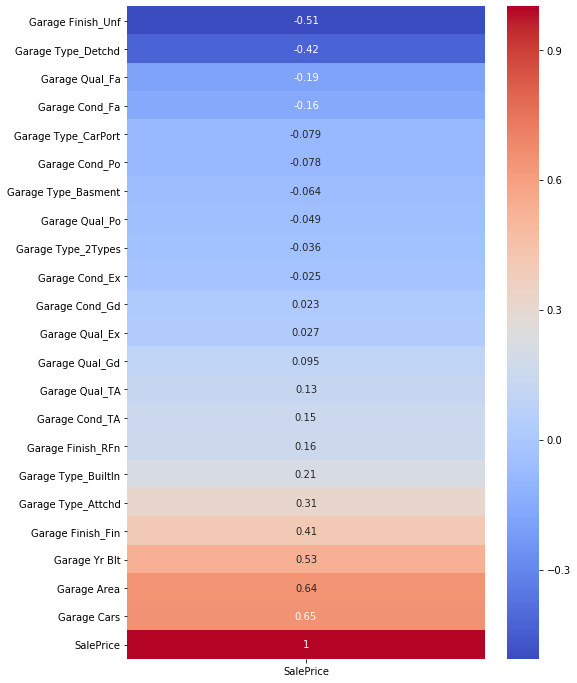

In [21]:
plt.figure(figsize = (8,12))
sns.heatmap(new_garage.corr()[['SalePrice']].sort_values(by='SalePrice'),cmap='coolwarm',annot=True);

In [22]:
garage['Garage Finish'].value_counts()

Unf    849
RFn    579
Fin    509
Name: Garage Finish, dtype: int64

The garage finish seems potentially promising, what if i combine those columns into one column of refinished/finished = 1, unfinished =0

In [23]:
garage['finish'] = garage['Garage Finish'].map(lambda x: 1 if (x == 'Fin')|(x == 'RFn') else 0)

In [24]:
#verify change
garage[['finish','Garage Finish']].head()

,finish,Garage Finish
0,1,RFn
1,1,RFn
2,0,Unf
3,1,Fin
4,0,Unf


In [25]:
garage_2 = garage[['finish','Garage Area','Garage Cars','SalePrice']]

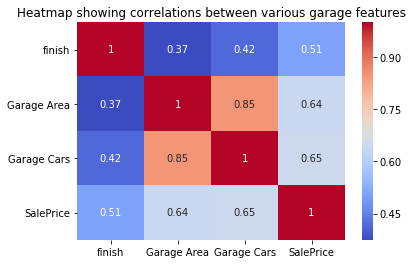

In [26]:
plt.title('Heatmap showing correlations between various garage features')
sns.heatmap(garage_2.corr(),cmap='coolwarm',annot=True);

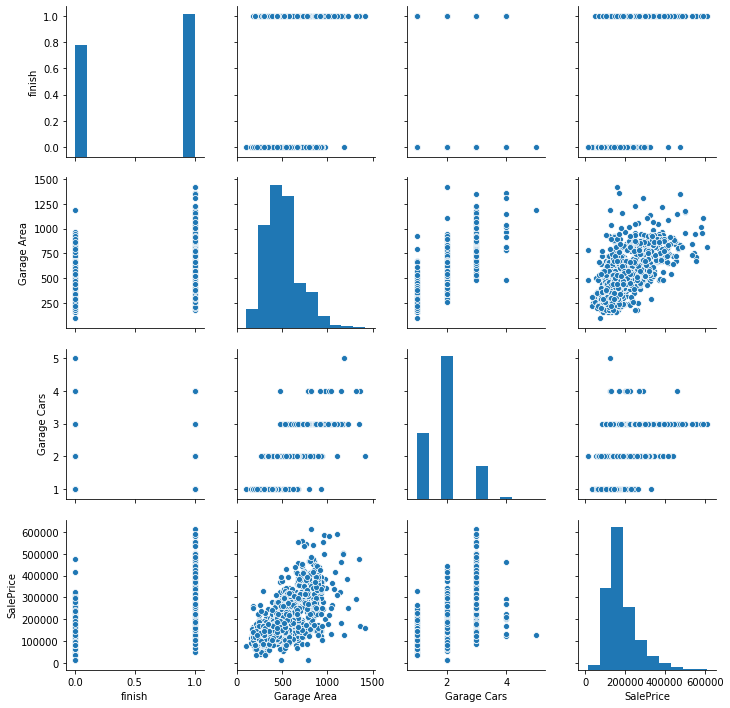

In [27]:
sns.pairplot(garage_2);

There's a high correlation, as one would expect between garage area and garage cars, let's create an interaction. 

In [28]:
garage['interaction']=garage['Garage Area']*garage['Garage Cars']

Overall conclusion from garage related data is garage area and cars are tightly correlated together so I'm going to include both columns and the interaction. I won't include the finish column since it doesn't seem that valuable had has about 100 lines of missing data that I would need to address in some way. I'm dropping all other garage columns.

In [29]:
train.drop(columns=['Garage Type','Garage Yr Blt','Garage Qual','Garage Cond','Garage Finish'],inplace = True)

In [30]:
train.isnull().sum().sort_values(ascending=False).head(17)

Lot Frontage      330
Bsmt Exposure      58
BsmtFin Type 2     56
Bsmt Cond          55
BsmtFin Type 1     55
Bsmt Qual          55
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
Garage Area         1
BsmtFin SF 1        1
Exter Qual          0
dtype: int64

There's only one or two rows with no garage area or cars so let's drop those

In [31]:
train.dropna(subset=['Garage Area','Garage Cars'],inplace=True)

In [32]:
train['garage interaction']=train['Garage Area']*train['Garage Cars']

In [33]:
#verifying column drop
train.shape

(2050, 72)

In [34]:
train.isnull().sum().sort_values(ascending=False).head(15)

Lot Frontage      330
Bsmt Exposure      58
BsmtFin Type 2     56
BsmtFin Type 1     55
Bsmt Qual          55
Bsmt Cond          55
Mas Vnr Area       22
Mas Vnr Type       22
Bsmt Half Bath      2
Bsmt Full Bath      2
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Exterior 1st        0
dtype: int64

Most of the remanining, missing values are in the basement features, let's dive in and see which specific features have value

In [35]:
basement = train[['BsmtFin SF 1','Total Bsmt SF','Bsmt Unf SF','BsmtFin SF 2','Bsmt Full Bath','Bsmt Half Bath',\
    'Bsmt Qual','Bsmt Cond','BsmtFin Type 1','BsmtFin Type 2','Bsmt Exposure','SalePrice']].copy()

In [36]:
basement.shape

(2050, 12)

In [37]:
#dropping rows with missing data just for analysis
basement.dropna().shape

(1991, 12)

In [38]:
basement.dtypes

BsmtFin SF 1      float64
Total Bsmt SF     float64
Bsmt Unf SF       float64
BsmtFin SF 2      float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Bsmt Qual          object
Bsmt Cond          object
BsmtFin Type 1     object
BsmtFin Type 2     object
Bsmt Exposure      object
SalePrice           int64
dtype: object

In [39]:
basement.head()

,BsmtFin SF 1,Total Bsmt SF,Bsmt Unf SF,BsmtFin SF 2,Bsmt Full Bath,Bsmt Half Bath,Bsmt Qual,Bsmt Cond,BsmtFin Type 1,BsmtFin Type 2,Bsmt Exposure,SalePrice
0,533.0,725.0,192.0,0.0,0.0,0.0,TA,TA,GLQ,Unf,No,130500
1,637.0,913.0,276.0,0.0,1.0,0.0,Gd,TA,GLQ,Unf,No,220000
2,731.0,1057.0,326.0,0.0,1.0,0.0,TA,TA,GLQ,Unf,No,109000
3,0.0,384.0,384.0,0.0,0.0,0.0,Gd,TA,Unf,Unf,No,174000
4,0.0,676.0,676.0,0.0,0.0,0.0,Fa,Gd,Unf,Unf,No,138500


Convert string data to numerical data if possible since generally that's better for regression models

Bsmt Qual (Ordinal): Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

In [40]:
basement['Bsmt Qual'] = basement['Bsmt Qual'].map({'Ex':10,'Gd':9,'TA':8,'Fa':7,'Po':6,'NA':0})

Bsmt Cond (Ordinal): Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

In [41]:
basement['Bsmt Cond'] = basement['Bsmt Cond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})

Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

In [42]:
basement['Bsmt Exposure'] = basement['Bsmt Exposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0})

BsmtFin Type 1 & 2	(Ordinal): Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Let's do a scatter to see if this data is usable

In [43]:
basement['BsmtFin Type 1 mod'] = basement['BsmtFin Type 1'].map({'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA':1})
basement['BsmtFin Type 2 mod'] = basement['BsmtFin Type 2'].map({'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA':1})

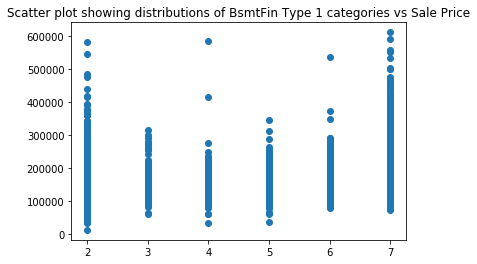

In [44]:
plt.title('Scatter plot showing distributions of BsmtFin Type 1 categories vs Sale Price')
plt.scatter(basement['BsmtFin Type 1 mod'],basement['SalePrice']);

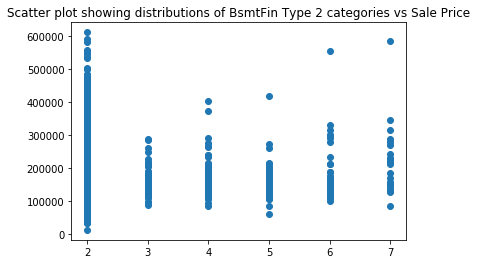

In [45]:
plt.title('Scatter plot showing distributions of BsmtFin Type 2 categories vs Sale Price')
plt.scatter(basement['BsmtFin Type 2 mod'],basement['SalePrice']);

Conclusion is that type 2 looks unusable, type 1 could be minorly useful but given we'd have to eliminate 50 rows to address nulls for it and we're likely to have too many features, I'd say it's not that useful and remove them
- in retrospect, here's another feature that I'd probably keep as dummy columns

In [46]:
basement.drop(['BsmtFin Type 1','BsmtFin Type 2','BsmtFin Type 1 mod','BsmtFin Type 2 mod'],axis=1,inplace=True)

Combine basement bathroom columns

In [47]:
basement['Bsmt Bath'] = basement['Bsmt Full Bath']+(.5*basement['Bsmt Half Bath'])

In [48]:
#verify that the above worked
basement[basement['Bsmt Bath']>1].head()

,BsmtFin SF 1,Total Bsmt SF,Bsmt Unf SF,BsmtFin SF 2,Bsmt Full Bath,Bsmt Half Bath,Bsmt Qual,Bsmt Cond,Bsmt Exposure,SalePrice,Bsmt Bath
133,1619.0,1719.0,100.0,0.0,2.0,0.0,9.0,3.0,4.0,324000,2.0
191,51.0,966.0,0.0,915.0,2.0,0.0,9.0,4.0,4.0,279000,2.0
194,500.0,1248.0,748.0,0.0,1.0,1.0,8.0,3.0,1.0,200000,1.5
289,1309.0,1344.0,35.0,0.0,2.0,0.0,9.0,4.0,4.0,206300,2.0
346,648.0,648.0,0.0,0.0,1.0,1.0,8.0,4.0,3.0,145000,1.5


In [49]:
basement.drop(['Bsmt Full Bath','Bsmt Half Bath'],axis=1,inplace=True)

In [50]:
basement.dtypes

BsmtFin SF 1     float64
Total Bsmt SF    float64
Bsmt Unf SF      float64
BsmtFin SF 2     float64
Bsmt Qual        float64
Bsmt Cond        float64
Bsmt Exposure    float64
SalePrice          int64
Bsmt Bath        float64
dtype: object

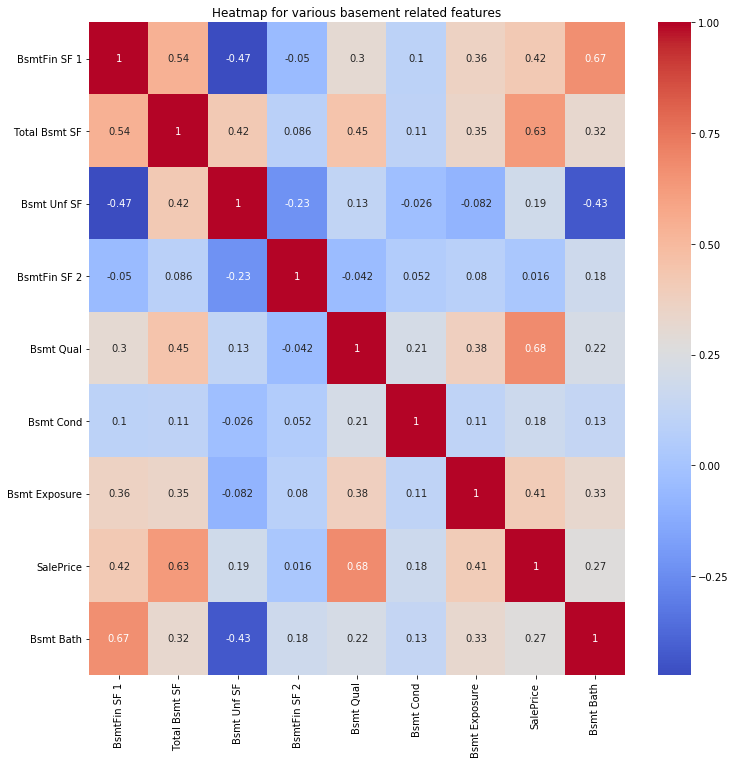

In [51]:
plt.figure(figsize = (12,12))
plt.title('Heatmap for various basement related features')
sns.heatmap(basement.corr(),cmap='coolwarm',annot=True);

Conclusion, keep the Total Bsmt SF and Bsmt Qual columns, drop the rest. Not creating any interaction terms since there's not a strong correlation between any of the columns

Apply basement changes to train

In [52]:
train.shape

(2050, 72)

In [53]:
train.drop(['BsmtFin SF 1','Bsmt Unf SF','BsmtFin SF 2','Bsmt Full Bath','Bsmt Half Bath',\
    'Bsmt Cond','BsmtFin Type 1','BsmtFin Type 2','Bsmt Exposure'],axis=1,inplace=True)

In [54]:
train.shape

(2050, 63)

In [55]:
#apply my basement quality transform
train['Bsmt Qual'] = train['Bsmt Qual'].map({'Ex':10,'Gd':9,'TA':8,'Fa':7,'Po':6,'NA':0})

In [56]:
train.isnull().sum().sort_values(ascending=False).head(7)

Lot Frontage     330
Bsmt Qual         55
Mas Vnr Area      22
Mas Vnr Type      22
Total Bsmt SF      1
House Style        0
Exter Cond         0
dtype: int64

There's 55 missing Bsmt Qual rows, let's impute a value of the average of all homes for this since we want to use this field in our model

In [57]:
#identify mean basement quality value to replace for nulls
train['Bsmt Qual'].sum()/(2050-55)

8.585964912280701

In [58]:
#actually convert my basement quality nulls to mean value
train['Bsmt Qual'] = train['Bsmt Qual'].fillna(8.586)

In [59]:
#verify
train[train['Bsmt Qual'].isnull()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,garage interaction


Drop the one row without Total Bsmt SF

In [60]:
train.dropna(subset=['Total Bsmt SF'],inplace=True)

Address Lot Frontage and Mas Vnr columns

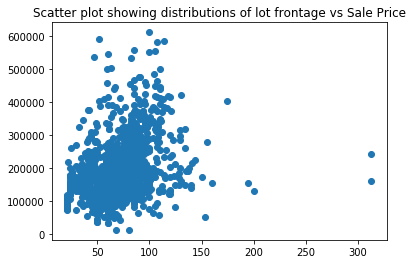

In [61]:
plt.title('Scatter plot showing distributions of lot frontage vs Sale Price')
plt.scatter(train['Lot Frontage'],train['SalePrice']);

In [62]:
train['Lot Frontage'].corr(train['SalePrice'])

0.3429869109509924

That's not a great correlation score, will drop column

Mas Vnr Type (Nominal): Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
Mas Vnr Area (Continuous): Masonry veneer area in square feet


In [63]:
train['Mas Type Mod'] = train['Mas Vnr Type'].map({'BrkCmn':5,'BrkFace':4,'CBlock':3,'Stone':2,'None':1})

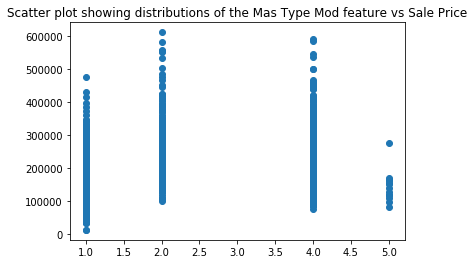

In [64]:
plt.title('Scatter plot showing distributions of the Mas Type Mod feature vs Sale Price')
plt.scatter(train['Mas Type Mod'],train['SalePrice']);

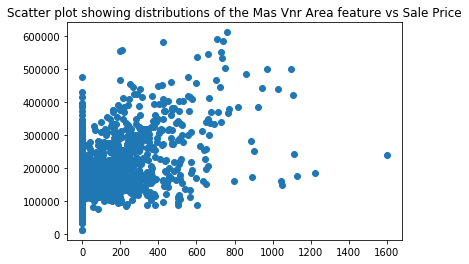

In [65]:
plt.title('Scatter plot showing distributions of the Mas Vnr Area feature vs Sale Price')
plt.scatter(train['Mas Vnr Area'],train['SalePrice']);

Definitely removing the Mas Vnr Area column, also removing the Mas Vnr Type column, that column appears to have some value but I'm not really sure how to address the nulls for it and we currently have an issue of having too many features as opposed to too few

In [66]:
train.drop(['Lot Frontage','Mas Vnr Area','Mas Type Mod','Mas Vnr Type'],axis=1,inplace=True)

In [67]:
train.shape

(2049, 60)

In [68]:
train.isnull().sum().sum()

0

**Continue EDA and Feature Engineering**

Full and Half Baths are probably a columns that we should combine since they're tightly connected. Also having a house age column as opposed to year built and year sold is more useful. Let's also remove the ID and PID columns since we don't want our model using those

In [69]:
train['bath'] = train['Full Bath']+(.5*train['Half Bath'])

In [70]:
train.shape

(2049, 61)

In [71]:
train.drop(['Full Bath','Half Bath','Id','PID'],axis=1,inplace=True)

In [72]:
train['age'] = train['Yr Sold'] - train['Year Built']
train.drop(['Year Built','Yr Sold'],axis=1,inplace=True)

In [73]:
train.shape

(2049, 56)

In [74]:
train.dtypes

MS SubClass             int64
MS Zoning              object
Lot Area                int64
Street                 object
Lot Shape              object
Land Contour           object
Utilities              object
Lot Config             object
Land Slope             object
Neighborhood           object
Condition 1            object
Condition 2            object
Bldg Type              object
House Style            object
Overall Qual            int64
Overall Cond            int64
Year Remod/Add          int64
Roof Style             object
Roof Matl              object
Exterior 1st           object
Exterior 2nd           object
Exter Qual             object
Exter Cond             object
Foundation             object
Bsmt Qual             float64
Total Bsmt SF         float64
Heating                object
Heating QC             object
Central Air            object
Electrical             object
1st Flr SF              int64
2nd Flr SF              int64
Low Qual Fin SF         int64
Gr Liv Are

MS subclass is an integer but the data dictionary shows this as more of a column, is this valuable info?

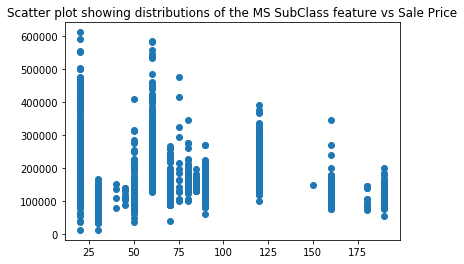

In [75]:
plt.title('Scatter plot showing distributions of the MS SubClass feature vs Sale Price')
plt.scatter(train['MS SubClass'],train['SalePrice']);

Data doesn't look very correlated, dropping this column

In [76]:
train.drop(['MS SubClass'],axis=1,inplace=True)

Plan for categorical columns, review each and determine if any of these seem relevant, only include ones that do

In [77]:
train['Street'].value_counts()

Pave    2042
Grvl       7
Name: Street, dtype: int64

In [78]:
train['Utilities'].value_counts()

AllPub    2047
NoSewr       1
NoSeWa       1
Name: Utilities, dtype: int64

In [79]:
train['Neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
SawyerW     87
NWAmes      87
Mitchel     82
BrkSide     75
Crawfor     71
IDOTRR      68
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

In [80]:
train['Condition 1'].value_counts()

Norm      1766
Feedr      108
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: Condition 1, dtype: int64

In [81]:
train['Condition 2'].value_counts()

Norm      2023
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition 2, dtype: int64

In [82]:
train['Bldg Type'].value_counts()

1Fam      1698
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: Bldg Type, dtype: int64

In [83]:
train['House Style'].value_counts()

1Story    1058
2Story     597
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: House Style, dtype: int64

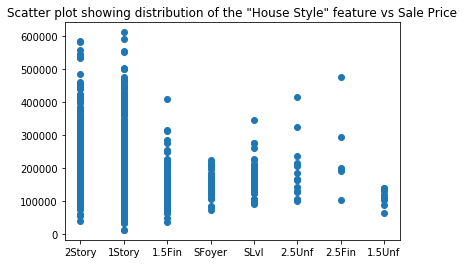

In [84]:
plt.title('Scatter plot showing distribution of the "House Style" feature vs Sale Price')
plt.scatter(train['House Style'],train['SalePrice']);

In [85]:
train['Exterior 1st'].value_counts()

VinylSd    724
MetalSd    330
HdBoard    300
Wd Sdng    275
Plywood    152
CemntBd     90
BrkFace     64
WdShing     45
AsbShng     33
Stucco      27
BrkComm      3
Stone        2
CBlock       2
AsphShn      1
ImStucc      1
Name: Exterior 1st, dtype: int64

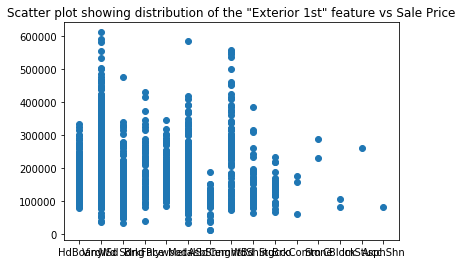

In [86]:
plt.title('Scatter plot showing distribution of the "Exterior 1st" feature vs Sale Price')
plt.scatter(train['Exterior 1st'],train['SalePrice']);

In [87]:
train['Exter Qual'].value_counts()

TA    1245
Gd     697
Ex      81
Fa      26
Name: Exter Qual, dtype: int64

In [88]:
train['Exter Cond'].value_counts()

TA    1776
Gd     215
Fa      49
Ex       7
Po       2
Name: Exter Cond, dtype: int64

In [89]:
train['Central Air'].value_counts()

Y    1908
N     141
Name: Central Air, dtype: int64

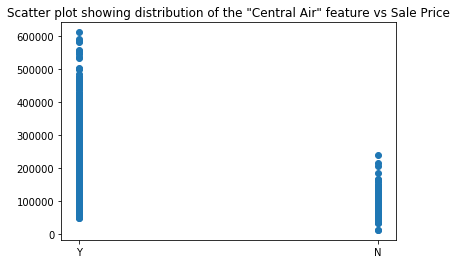

In [90]:
plt.title('Scatter plot showing distribution of the "Central Air" feature vs Sale Price')
plt.scatter(train['Central Air'],train['SalePrice']);

In [91]:
train['Kitchen Qual'].value_counts()

TA    1046
Gd     805
Ex     151
Fa      47
Name: Kitchen Qual, dtype: int64

In [92]:
train['Functional'].value_counts()

Typ     1913
Min2      42
Min1      42
Mod       29
Maj1      12
Maj2       7
Sal        2
Sev        2
Name: Functional, dtype: int64

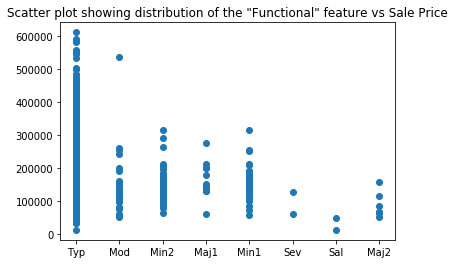

In [93]:
plt.title('Scatter plot showing distribution of the "Functional" feature vs Sale Price')
plt.scatter(train['Functional'],train['SalePrice']);

In [94]:
train['Paved Drive'].value_counts()

Y    1859
N     151
P      39
Name: Paved Drive, dtype: int64

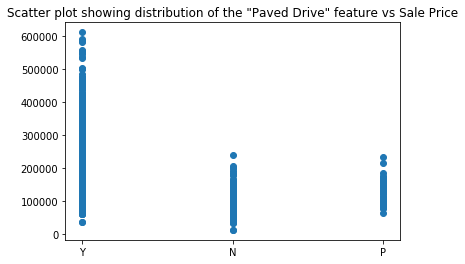

In [95]:
plt.title('Scatter plot showing distribution of the "Paved Drive" feature vs Sale Price')
plt.scatter(train['Paved Drive'],train['SalePrice']);

In [96]:
train['Sale Type'].value_counts()

WD       1780
New       160
COD        63
ConLD      16
CWD        10
ConLI       7
ConLw       5
Con         4
Oth         4
Name: Sale Type, dtype: int64

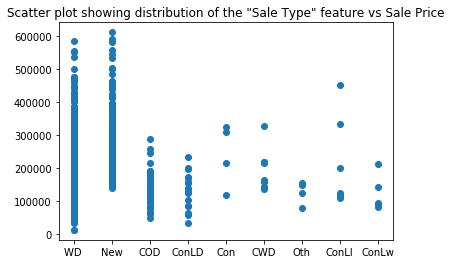

In [97]:
plt.title('Scatter plot showing distribution of the "Sale Type" feature vs Sale Price')
plt.scatter(train['Sale Type'],train['SalePrice']);


|Categorical Feature|Decision|
|---|---|
|MS Zoning|doesn't seem valuable enought to include
|Street|analyzed, not valuable
|Lot Shape|doesn't seem valuable enought to include but included after it helped generate a better model
|Land Contour|doesn't seem valuable enought to include but included after it helped generate a better model
|Utilities|analyzed, not valuable
|Lot Config|doesn't seem valuable enought to include
|Land Slope|doesn't seem valuable enought to include
|Neighborhood|seems valuable, may have blank columns that i need to fill with zeros, essentially don't drop first
|Condition 1|see analysis, doesn't seem like there's enough data to include, removing
|Condition 2|see analysis, doesn't seem like there's enough data to include, removing
|Bldg Type|seems valuable, may have blank columns that i need to fill with zeros, essentially don't drop first
|House Style|seems valuable, may have blank columns that i need to fill with zeros, essentially don't drop first
|Roof Style|doesn't seem valuable enought to include
|Roof Matl|doesn't seem valuable enought to include
|Exterior 1st|see analysis, doesn't seem like there's enough data to include, removing
|Exterior 2nd|see analysis, doesn't seem like there's enough data to include, removing
|Exter Qual|Initially wanted to map it numerically but switched to categorical after it produced a better model
|Exter Cond|Should be mapped numerically
|Foundation|doesn't seem valuable enought to include
|Heating|doesn't seem valuable enought to include
|Heating QC|useful, needs to be mapped
|Central Air|seems valuable, map with pd.dummies and drop 1st
|Electrical|doesn't seem valuable enought to include
|Kitchen Qual|Should be mapped numerically
|Functional|seems valuable, may have blank columns that i need to fill with zeros, essentially don't drop first
|Paved Drive|seems valuable, map with pd.dummies and drop 1st
|Sale Type|seems valuable, may have blank columns that i need to fill with zeros, essentially don't drop first

In [98]:
train.drop(['MS Zoning','Street','Utilities','Lot Config','Land Slope','Condition 1','Condition 2',\
'Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Foundation','Heating','Electrical'],axis=1,inplace=True)

In [99]:
train.shape

(2049, 41)

Analyze numeric columns

In [100]:
train.dtypes

Lot Area                int64
Lot Shape              object
Land Contour           object
Neighborhood           object
Bldg Type              object
House Style            object
Overall Qual            int64
Overall Cond            int64
Year Remod/Add          int64
Exter Qual             object
Exter Cond             object
Bsmt Qual             float64
Total Bsmt SF         float64
Heating QC             object
Central Air            object
1st Flr SF              int64
2nd Flr SF              int64
Low Qual Fin SF         int64
Gr Liv Area             int64
Bedroom AbvGr           int64
Kitchen AbvGr           int64
Kitchen Qual           object
TotRms AbvGrd           int64
Functional             object
Fireplaces              int64
Garage Cars           float64
Garage Area           float64
Paved Drive            object
Wood Deck SF            int64
Open Porch SF           int64
Enclosed Porch          int64
3Ssn Porch              int64
Screen Porch            int64
Pool Area 

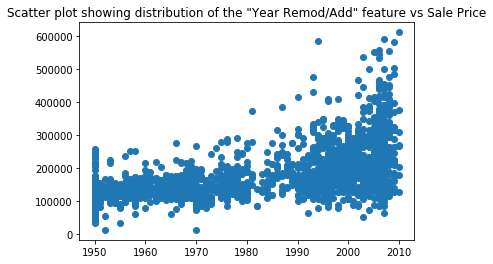

In [101]:
plt.title('Scatter plot showing distribution of the "Year Remod/Add" feature vs Sale Price')
plt.scatter(train['Year Remod/Add'],train['SalePrice']);
#slight correlation, not worth keeping

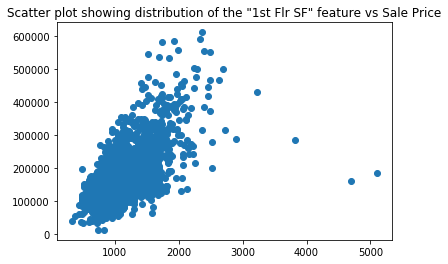

In [102]:
plt.title('Scatter plot showing distribution of the "1st Flr SF" feature vs Sale Price')
plt.scatter(train['1st Flr SF'],train['SalePrice']);

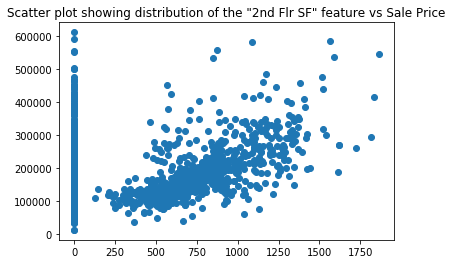

In [103]:
plt.title('Scatter plot showing distribution of the "2nd Flr SF" feature vs Sale Price')
plt.scatter(train['2nd Flr SF'],train['SalePrice']);

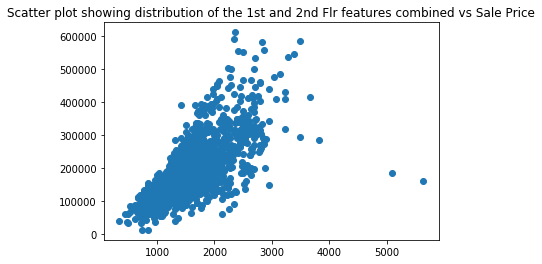

In [104]:
plt.title('Scatter plot showing distribution of the 1st and 2nd Flr features combined vs Sale Price')
plt.scatter(train['1st Flr SF']+train['2nd Flr SF'],train['SalePrice']);
#need to combine the sq ft columns

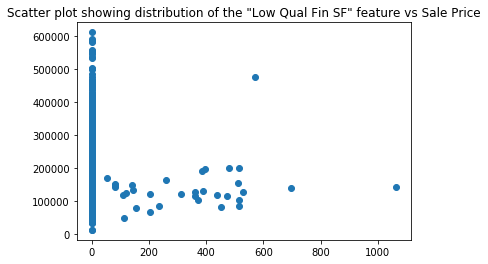

In [105]:
plt.title('Scatter plot showing distribution of the "Low Qual Fin SF" feature vs Sale Price')
plt.scatter(train['Low Qual Fin SF'],train['SalePrice']);
#worthless, remove

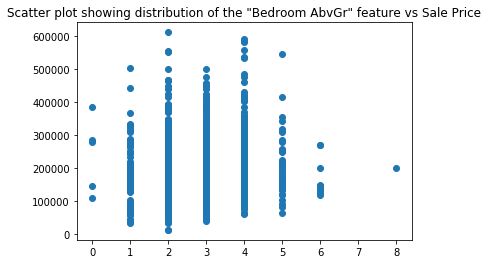

In [106]:
plt.title('Scatter plot showing distribution of the "Bedroom AbvGr" feature vs Sale Price')
plt.scatter(train['Bedroom AbvGr'],train['SalePrice']);
#worthless, remove

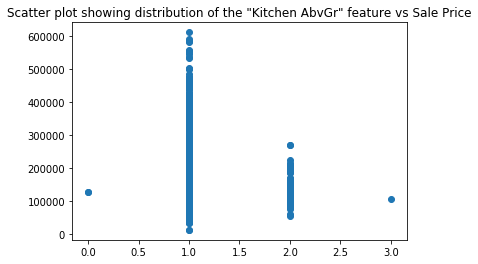

In [107]:
plt.title('Scatter plot showing distribution of the "Kitchen AbvGr" feature vs Sale Price')
plt.scatter(train['Kitchen AbvGr'],train['SalePrice']);
#worthless, remove

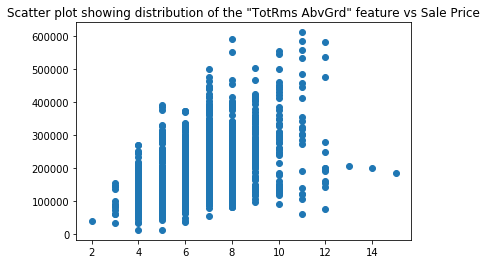

In [108]:
plt.title('Scatter plot showing distribution of the "TotRms AbvGrd" feature vs Sale Price')
plt.scatter(train['TotRms AbvGrd'],train['SalePrice']);

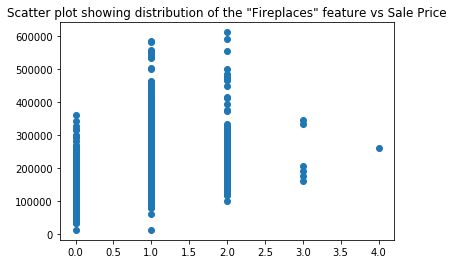

In [109]:
plt.title('Scatter plot showing distribution of the "Fireplaces" feature vs Sale Price')
plt.scatter(train['Fireplaces'],train['SalePrice']);

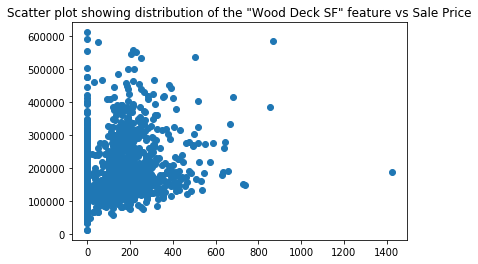

In [110]:
plt.title('Scatter plot showing distribution of the "Wood Deck SF" feature vs Sale Price')
plt.scatter(train['Wood Deck SF'],train['SalePrice']);
#not valuable enough, removing

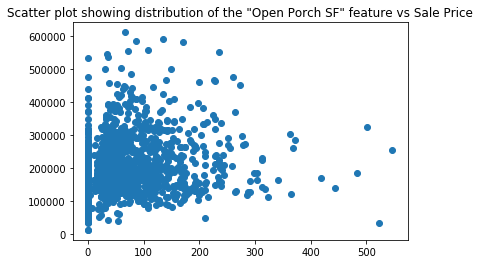

In [111]:
plt.title('Scatter plot showing distribution of the "Open Porch SF" feature vs Sale Price')
plt.scatter(train['Open Porch SF'],train['SalePrice']);
#not valuable enough, removing

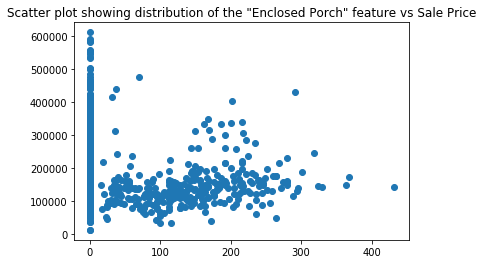

In [112]:
plt.title('Scatter plot showing distribution of the "Enclosed Porch" feature vs Sale Price')
plt.scatter(train['Enclosed Porch'],train['SalePrice']);
#not valuable enough, removing

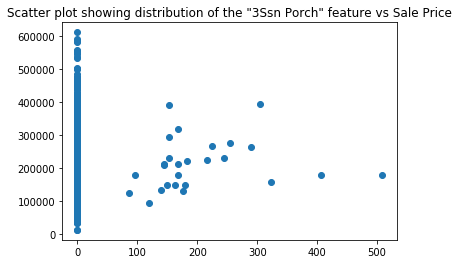

In [113]:
plt.title('Scatter plot showing distribution of the "3Ssn Porch" feature vs Sale Price')
plt.scatter(train['3Ssn Porch'],train['SalePrice']);
#not valuable enough, removing

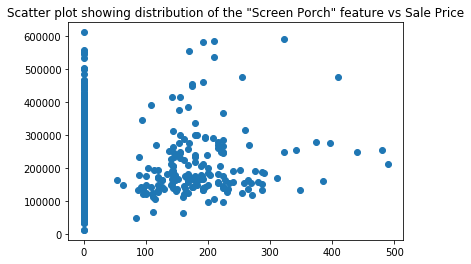

In [114]:
plt.title('Scatter plot showing distribution of the "Screen Porch" feature vs Sale Price')
plt.scatter(train['Screen Porch'],train['SalePrice']);
#this doesn't seem valuable but seems to help my model a lot so keeping it

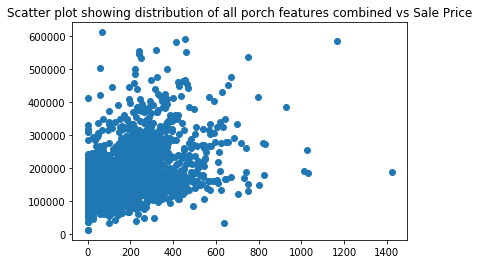

In [115]:
plt.title('Scatter plot showing distribution of all porch features combined vs Sale Price')
plt.scatter(train['Screen Porch']+train['3Ssn Porch']+train['Enclosed Porch']+train['Open Porch SF']\
            +train['Wood Deck SF'],train['SalePrice']);

In [116]:
(train['Screen Porch']+train['3Ssn Porch']+train['Enclosed Porch']+train['Open Porch SF']\
            +train['Wood Deck SF']).corr(train['SalePrice'])
#correlation isn't that strong and it's not really correct to just add up porch sq. footage since that could
#double count some info, dropping  all columns except screen porch

0.4063243609335858

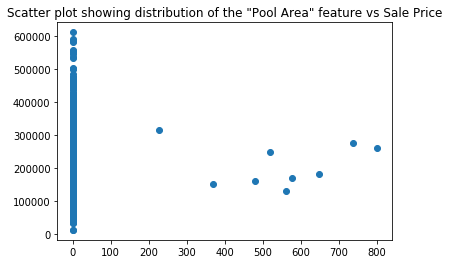

In [117]:
plt.title('Scatter plot showing distribution of the "Pool Area" feature vs Sale Price')
plt.scatter(train['Pool Area'],train['SalePrice']);
#not valuable enough, removing

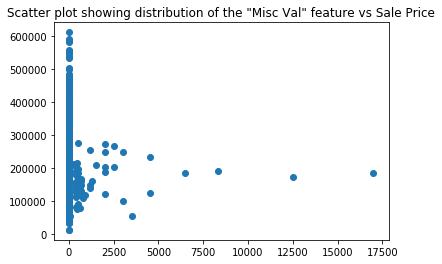

In [118]:
plt.title('Scatter plot showing distribution of the "Misc Val" feature vs Sale Price')
plt.scatter(train['Misc Val'],train['SalePrice']);
#seems valuable, keeping

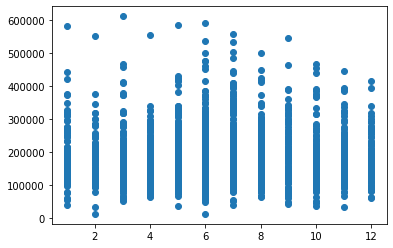

In [119]:
plt.scatter(train['Mo Sold'],train['SalePrice']);
#will be valuable if we convert to a string

In [120]:
train.drop(['Pool Area','3Ssn Porch','Enclosed Porch','Open Porch SF','Wood Deck SF',\
'Kitchen AbvGr','Bedroom AbvGr','Low Qual Fin SF','Year Remod/Add'],axis=1,inplace=True)

Apply all of the transforms that I mentioned above

In [121]:
train['SF']=train['1st Flr SF']+train['2nd Flr SF']

In [122]:
train.drop(['1st Flr SF','2nd Flr SF'],axis=1,inplace=True)

In [123]:
train['Mo Sold'].value_counts()

6     352
7     303
5     257
4     207
3     167
8     167
10    123
9     109
2     104
11    103
1      79
12     78
Name: Mo Sold, dtype: int64

In [124]:
train['Mo Sold'] = train['Mo Sold'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',\
                                        9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

Mapping these three columns to numeric values for better use in regresion models

Exter Cond (Ordinal)
HeatingQC (Ordinal)
KitchenQual (Ordinal)

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor


In [125]:
train['Exter Cond'] = train['Exter Cond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

In [126]:
train['Heating QC'] = train['Heating QC'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

In [127]:
train['Kitchen Qual'] = train['Kitchen Qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

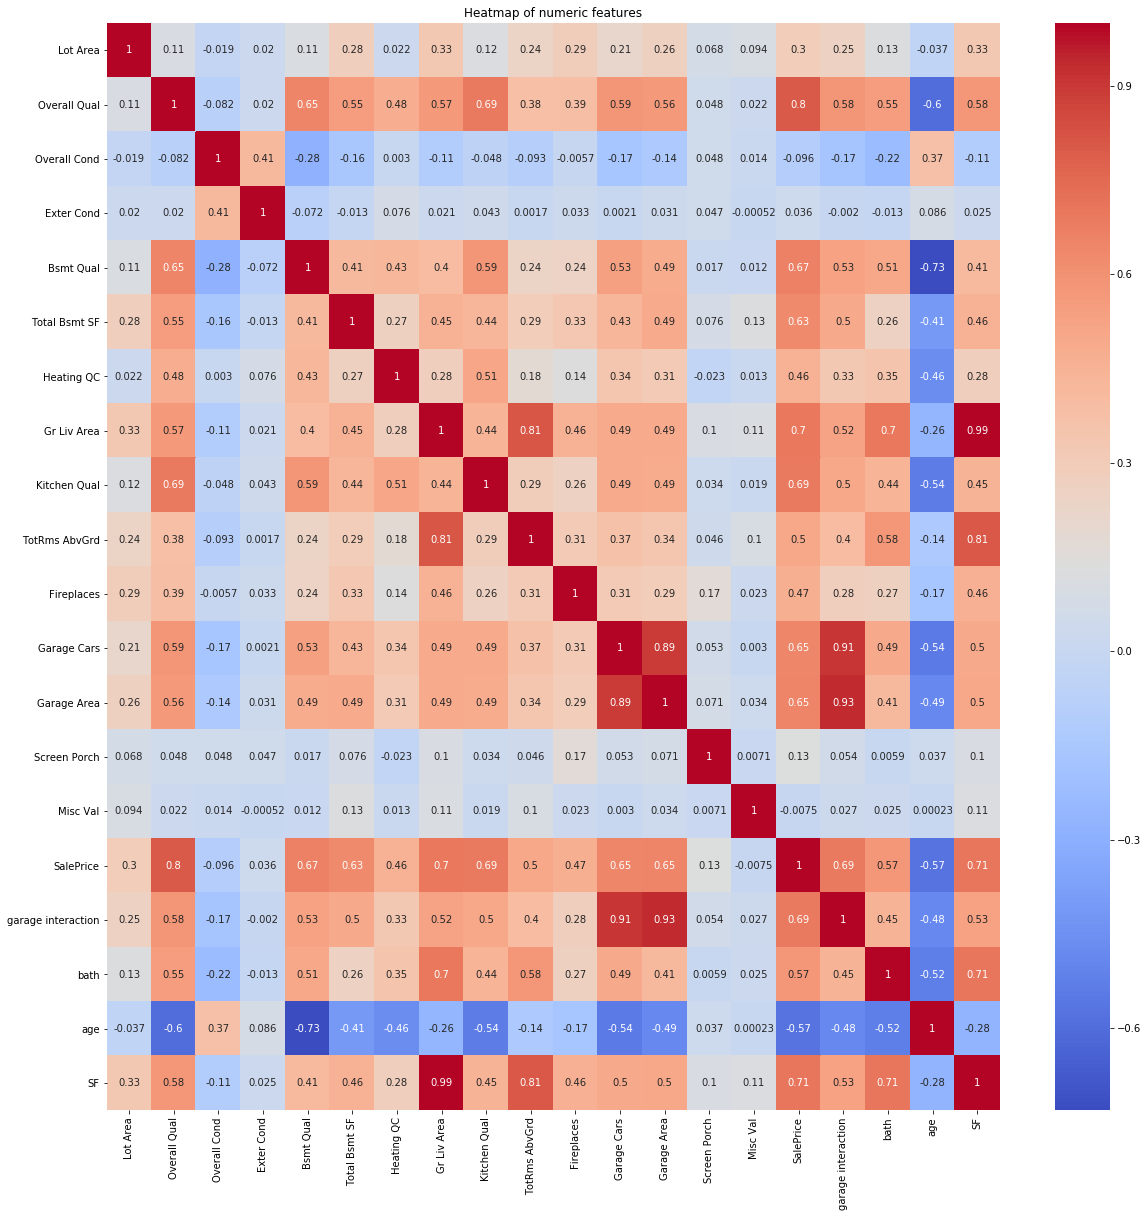

In [128]:
plt.figure(figsize=(20,20))
plt.title('Heatmap of numeric features')
sns.heatmap(train.corr(),annot=True,cmap='coolwarm');

Noted that the Overall Cond and Exter Cond seem to have negative correlations on our model, going to investigate those. As noted above, keeping screen porch and misc val for model performance reasons.

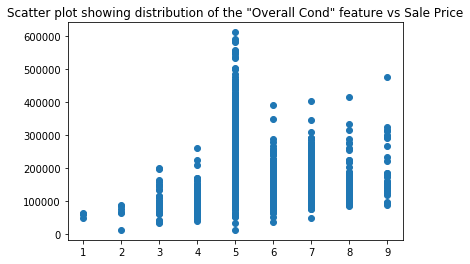

In [129]:
plt.title('Scatter plot showing distribution of the "Overall Cond" feature vs Sale Price')
plt.scatter(train['Overall Cond'],train['SalePrice']);

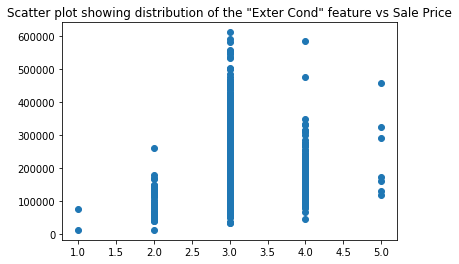

In [130]:
plt.title('Scatter plot showing distribution of the "Exter Cond" feature vs Sale Price')
plt.scatter(train['Exter Cond'],train['SalePrice']);

These two columns should be removed
- in retrospect, probably worth investigating if those could be kept and used as categorical/dummy columns

In [131]:
train.drop(['Exter Cond','Overall Cond'],axis=1,inplace=True)

**Convert Categorical Columns to Dummies**

In [132]:
train.shape

(2049, 29)

In [133]:
train.dtypes

Lot Area                int64
Lot Shape              object
Land Contour           object
Neighborhood           object
Bldg Type              object
House Style            object
Overall Qual            int64
Exter Qual             object
Bsmt Qual             float64
Total Bsmt SF         float64
Heating QC              int64
Central Air            object
Gr Liv Area             int64
Kitchen Qual            int64
TotRms AbvGrd           int64
Functional             object
Fireplaces              int64
Garage Cars           float64
Garage Area           float64
Paved Drive            object
Screen Porch            int64
Misc Val                int64
Mo Sold                object
Sale Type              object
SalePrice               int64
garage interaction    float64
bath                  float64
age                     int64
SF                      int64
dtype: object

In [134]:
train['Sale Type'].value_counts()

WD       1780
New       160
COD        63
ConLD      16
CWD        10
ConLI       7
ConLw       5
Con         4
Oth         4
Name: Sale Type, dtype: int64

In [135]:
train['Functional'].value_counts()

Typ     1913
Min2      42
Min1      42
Mod       29
Maj1      12
Maj2       7
Sal        2
Sev        2
Name: Functional, dtype: int64

In [136]:
train['Central Air'].value_counts()

Y    1908
N     141
Name: Central Air, dtype: int64

The difference in the drop_first columns are that I was initilly thinking we wouldn't want to do a drop_first on columns with low value counts since those columns might be missing in our test data set. In retrospect, I actually ended up dropping columns with LASSO so I don't think I'd want to use drop_first at all since you should only use that parameter if you're keeping all your other parameters. If I had more time, this would be the first thing I would test/change to see how it affected my model

In [137]:
train = pd.get_dummies(train,columns=['Exter Qual','Land Contour','Lot Shape'],drop_first = True)

In [138]:
train = pd.get_dummies(train,columns=['Paved Drive','Central Air'],drop_first = True)

In [139]:
train = pd.get_dummies(train,columns=['Mo Sold'],drop_first = True)

In [140]:
train = pd.get_dummies(train,columns=['Neighborhood','Bldg Type','House Style','Functional','Sale Type'])

In [141]:
train.head()

,Lot Area,Overall Qual,Bsmt Qual,Total Bsmt SF,Heating QC,Gr Liv Area,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,...,Functional_Typ,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,13517,6,8.0,725.0,5,1479,4,6,0,2.0,...,1,0,0,0,0,0,0,0,0,1
1,11492,7,9.0,913.0,5,2122,4,8,1,2.0,...,1,0,0,0,0,0,0,0,0,1
2,7922,5,8.0,1057.0,3,1057,4,5,0,1.0,...,1,0,0,0,0,0,0,0,0,1
3,9802,5,9.0,384.0,4,1444,3,7,0,2.0,...,1,0,0,0,0,0,0,0,0,1
4,14235,6,7.0,676.0,3,1445,3,6,0,2.0,...,1,0,0,0,0,0,0,0,0,1


**Apply all relevant changes to test data**

In [142]:
test.drop(columns=['Alley','Fireplace Qu','Pool QC','Fence','Misc Feature'],inplace = True)

In [143]:
test.isnull().sum().sort_values(ascending=False).head(20)

Lot Frontage      160
Garage Qual        45
Garage Cond        45
Garage Yr Blt      45
Garage Finish      45
Garage Type        44
BsmtFin Type 1     25
Bsmt Exposure      25
Bsmt Qual          25
Bsmt Cond          25
BsmtFin Type 2     25
Mas Vnr Area        1
Electrical          1
Mas Vnr Type        1
Exter Qual          0
Exter Cond          0
Overall Cond        0
Exterior 2nd        0
Foundation          0
Exterior 1st        0
dtype: int64

In [144]:
test['garage interaction']=test['Garage Area']*test['Garage Cars']

In [145]:
test.drop(columns=['Garage Type','Garage Yr Blt','Garage Qual','Garage Cond','Garage Finish'],inplace = True)

In [146]:
test.drop(['BsmtFin SF 1','Bsmt Unf SF','BsmtFin SF 2','Bsmt Full Bath','Bsmt Half Bath',\
    'Bsmt Cond','BsmtFin Type 1','BsmtFin Type 2','Bsmt Exposure'],axis=1,inplace=True)

In [147]:
test['Bsmt Qual'] = test['Bsmt Qual'].map({'Ex':10,'Gd':9,'TA':8,'Fa':7,'Po':6,'NA':0})

In [148]:
test['Bsmt Qual'] = test['Bsmt Qual'].fillna(8.586)

In [149]:
test.drop(['Lot Frontage','Mas Vnr Area','Mas Vnr Type'],axis=1,inplace=True)

In [150]:
test.isnull().sum().sort_values(ascending=False).head()

Electrical            1
garage interaction    0
Total Bsmt SF         0
Foundation            0
Exter Cond            0
dtype: int64

In [151]:
test['bath'] = test['Full Bath']+(.5*test['Half Bath'])

In [152]:
test.drop(['Full Bath','Half Bath','PID'],axis=1,inplace=True)

In [153]:
test['age'] = test['Yr Sold'] - test['Year Built']
test.drop(['Year Built','Yr Sold'],axis=1,inplace=True)

In [154]:
test.drop(['MS SubClass'],axis=1,inplace=True)

In [155]:
test.drop(['MS Zoning','Street','Utilities','Lot Config','Land Slope','Condition 1','Condition 2',\
'Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Foundation','Heating','Electrical'],axis=1,inplace=True)

In [156]:
test.drop(['Pool Area','3Ssn Porch','Enclosed Porch','Open Porch SF','Wood Deck SF',\
'Kitchen AbvGr','Bedroom AbvGr','Low Qual Fin SF','Year Remod/Add'],axis=1,inplace=True)

In [157]:
test['SF']=test['1st Flr SF']+test['2nd Flr SF']

In [158]:
test.drop(['1st Flr SF','2nd Flr SF'],axis=1,inplace=True)

In [159]:
test['Mo Sold'] = test['Mo Sold'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',\
                                        9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

In [160]:
test['Exter Cond'] = test['Exter Cond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
test['Heating QC'] = test['Heating QC'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
test['Kitchen Qual'] = test['Kitchen Qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})

In [161]:
test.drop(['Exter Cond','Overall Cond'],axis=1,inplace=True)

In [162]:
test = pd.get_dummies(test,columns=['Exter Qual','Land Contour','Lot Shape'],drop_first = True)
test = pd.get_dummies(test,columns=['Paved Drive','Mo Sold','Central Air'],drop_first = True)
test = pd.get_dummies(test,columns=['Neighborhood','Bldg Type','House Style','Functional','Sale Type'])

**rectify the difference in columns**

In [163]:
for name in test.columns:
    if name not in train.columns:
        print(name)

Id
Sale Type_VWD


In [164]:
for name in train.columns:
    if name not in test.columns:
        print(name)

SalePrice
Neighborhood_GrnHill
Neighborhood_Landmrk
Functional_Sal
Functional_Sev


The above searches show there are columns in my test or train dataset that aren't in the other. This is a result of using the pd_dummies command to create these columns. Modeling would require that both datasets have the same columns so I'll create the missing columns in each data set and assign a value of 0 for those columns

In [165]:
train['Sale Type_VWD']=0

In [166]:
test['Neighborhood_GrnHill']=0
test['Neighborhood_Landmrk']=0
test['Functional_Sal']=0
test['Functional_Sev']=0

In [167]:
train.shape

(2049, 100)

In [168]:
test.shape

(879, 100)

In [169]:
train.to_csv('clean_train.csv',index=False)

In [170]:
test.to_csv('clean_test.csv',index=False)

## EDA Conclusions ##

Based on the correlations we've seen here, I expect that we'll be able to create a model to predict home sale price.